<a href="https://colab.research.google.com/github/arpaiva/PINNs/blob/main/PINNs_BurgersPDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solve Burgers' PDE example using Physics-Informed Neural Nets (PINNs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd

In [ ]:
class BurgersPINN(nn.Module):
    """Physics-informed neural nets (PINNS) to solve Burgers' equation."""

    def __init__(self,
                 nn_arch=[16, 8],
                 activation_fcn=torch.nn.Tanh,
                 misfit_fcn=torch.nn.MSELoss(),
                 domain=(-1, 1, 0, 1),
                 n_initcond_pts=128,
                 n_boundary_pts=128,
                 n_collocation_pts=512,
                 device=None):
        """Args:
            nn_arch - number of nodes for each hidden layer of the dense NN
            activation_fcn - nn.Module nonlinearity class applied to the output
                      of hidden layer nodes (not applied to output layer)
            misfit_fcn  - training loss/objective function
            domain  - tuple of dimensions of the simulation domain with
                      format (x_lb, x_ub, t_start, t_end)
            n_initcond_pts - number of constraint boundary points
            n_boundary_pts - number of boundary points
            n_collocation_pts - number of points where to test and ensure
                      that the trained PINN solves the PDE 
            device  - compute device; defaults to "cuda:0" when available or
                      "cpu" otherwise
        """

        super().__init__()
        self._domain = domain
        self._nn_arch = nn_arch
        self._activation_fcn = activation_fcn
        self._misfit_fcn = misfit_fcn
        self._n_initcond_pts = n_initcond_pts
        self._n_boundary_pts = n_boundary_pts
        self._n_collocation_pts = n_collocation_pts

        if device:
            self._device = device
        else:
            self._device = "cuda:0" if torch.cuda.is_available() else "cpu"

        # initialize neural net representation of domain
        self._layers = []
        n_inputs = 2
        # .. add hidden layers
        for i, n_nodes in enumerate(nn_arch):
            self._layers.append(nn.Linear(n_inputs, n_nodes))
            self._layers.append(activation_fcn())
            n_inputs = n_nodes
        # .. add output layer
        self._layers.append(nn.Linear(n_inputs, 1))
        # .. combine layers
        self._model = nn.Sequential(*self._layers)

        self.to(self._device)

    def forward(self, x, t):
        return self._model(torch.cat([x, t], axis=1))

    def pde(self, x, t):
        """Burgers' PDE:
            f(x,t|u) = du/dt + u*(dx/dt) - (0.01/pi)(d^2x/dx^2) = 0.
        """
        
        u = self(x, t)
        u_t = autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x, create_graph=True)[0]
        #pdb.set_trace()
        return u_t + u*u_x - (0.01/np.pi)*u_xx

    def boundary_points(self):
        """Returns a batch of boundary points for training the PINN.
        Points are returned as a tuple (x, t, u).
        """

        # boundary condition points, i.e., u(x,t), x={-1, 1}
        x = np.where(np.random.rand(self._n_boundary_pts, 1) < 0.5,
                       self._domain[0], self._domain[1])
        t = np.random.uniform(low=self._domain[2], high=self._domain[3],
                              size=(self._n_boundary_pts, 1))
        u = np.zeros_like(x)

        return (self.numpy_to_tensor(x),
                self.numpy_to_tensor(t),
                self.numpy_to_tensor(u))

    def initial_condition_points(self, ic_func=None):
        """Returns a batch of boundary points for training the PINN.
        Points are returned as a tuple (x, t, u).
        """

        if not ic_func:
            ic_func = lambda x: -np.sin(np.pi * x)

        # initial condition points, i.e., u(x,t=0)
        x = np.random.uniform(low=self._domain[0], high=self._domain[1],
                              size=(self._n_initcond_pts, 1))
        t = np.full_like(x, self._domain[2])
        u = ic_func(x)

        return (self.numpy_to_tensor(x),
                self.numpy_to_tensor(t),
                self.numpy_to_tensor(u))

    def collocation_points(self):
        """Returns a batch of random collocation points."""
        
        # randomly sample locations in the (space x time) domain 
        x =  np.random.uniform(low=self._domain[0], high=self._domain[1],
                               size=(self._n_collocation_pts, 1))
        t = np.random.rand(self._n_collocation_pts, 1)

        x = self.numpy_to_tensor(x, grad=True)
        t = self.numpy_to_tensor(t, grad=True)

        return x, t

    def get_loss(self, mse_ic, mse_bc, mse_pde):
        """Returns combined loss and dict of individual component loss values."""
        losses = {'mse_ic': mse_ic.item(),
                  'mse_bc': mse_bc.item(),
                  'mse_pde': mse_pde.item()}
        return mse_ic + mse_bc + mse_pde, losses

    def train(self, learning_rate=1e-3, n_iter=1000, disp_iter=10,
              resample_initcond_pts=False,
              resample_boundary_pts=False,
              resample_collocation_points=True):
        
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, amsgrad=True)

        f_vals = self.numpy_to_tensor(np.zeros((self._n_collocation_pts, 1)))

        for it in range(n_iter):       
            if it==0 or resample_initcond_pts:
                xic, tic, uic = self.initial_condition_points()
            if it==0 or resample_boundary_pts:
                xbc, tbc, ubc = self.boundary_points()
            if it==0 or resample_collocation_points:
                x_col, t_col = self.collocation_points()

            # loss on initial condition points
            pred_uic = self(xic, tic)
            mse_ic = self._misfit_fcn(uic, pred_uic)

            # loss on boundary points
            pred_ubc = self(xbc, tbc)
            mse_bc = self._misfit_fcn(ubc, pred_ubc)

            # loss on collocation points
            pred_f = self.pde(x_col, t_col)
            mse_pde = self._misfit_fcn(f_vals, pred_f)

            # combined loss
            loss, losses = self.get_loss(mse_ic, mse_bc, mse_pde)

            # backprop + gradient step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if it % disp_iter == 0:
                print(f'[{it:5d}]',
                      ' '.join([f'{ln}={lv:.5f},' for ln, lv in losses.items()]),
                      f'loss={loss:.5f}')

    def numpy_to_tensor(self, x, grad=False):
        return torch.from_numpy(x).float().requires_grad_(grad).to(self._device)

In [ ]:
pinn = BurgersPINN(nn_arch=[32, 16, 16, 8], n_collocation_pts=1024)
print(pinn)

pinn.train(learning_rate=0.005, n_iter=10000, disp_iter=100)

BurgersPINN(
  (_misfit_fcn): MSELoss()
  (_model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
[    0] mse_ic=0.53167, mse_bc=0.08523, mse_pde=0.00001, loss=0.61690
[  100] mse_ic=0.07461, mse_bc=0.00431, mse_pde=0.03661, loss=0.11553
[  200] mse_ic=0.05956, mse_bc=0.00266, mse_pde=0.03511, loss=0.09733
[  300] mse_ic=0.04443, mse_bc=0.00309, mse_pde=0.03994, loss=0.08746
[  400] mse_ic=0.04376, mse_bc=0.00146, mse_pde=0.02671, loss=0.07194
[  500] mse_ic=0.03515, mse_bc=0.00227, mse_pde=0.02709, loss=0.06451
[  600] mse_ic=0.02625, mse_bc=0.00073, mse_pde=0.02795, loss=0.05493
[  700] mse_ic=0.02655, mse_bc=0.00044, mse_pde=0.01704, loss=0.04404
[  800] ms

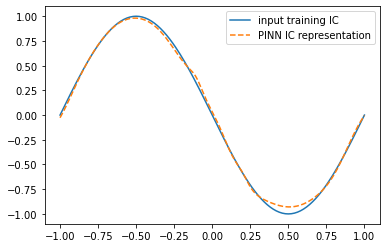

In [ ]:
xg, tg = np.meshgrid(np.linspace(-1, 1, 201), np.linspace(0, 1, 101))
# xg, tg = np.linspace(-1, 1, 201), np.zeros(201)
with torch.no_grad():
    u = pinn(pinn.numpy_to_tensor(xg.reshape((-1, 1))),
             pinn.numpy_to_tensor(tg.reshape((-1, 1))))

plt.plot(xg[0], -np.sin(np.pi*xg[0]), label='input training IC')
plt.plot(xg[0], u.numpy().reshape(xg.shape)[0], '--', label='PINN IC representation')
plt.legend()

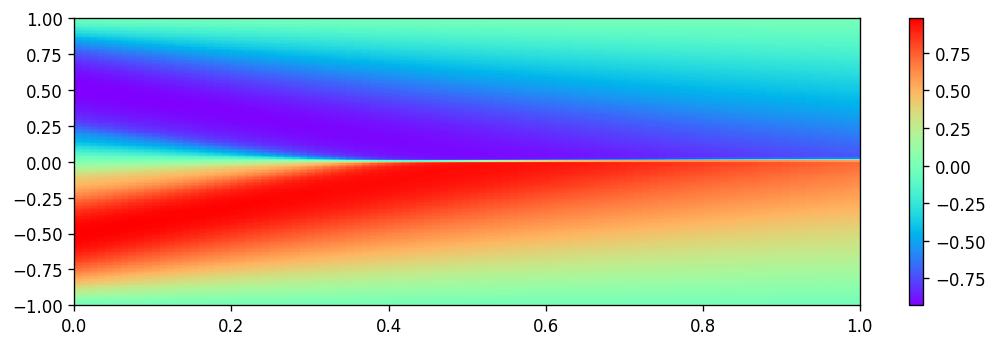

In [ ]:
plt.figure(figsize=(9, 3), dpi=120)
plt.imshow(u.numpy().reshape(xg.shape).T,
           cmap='rainbow',
           interpolation='nearest',
           extent=[0, 1, -1, 1],
           origin='lower',
           aspect='auto')
plt.colorbar()
plt.tight_layout();

# Compare pyTorch autograd approaches
There are two ways to obtain the (partial) derivatives/gradients of a pyTorch function (e.g., neural net):
 * _Using `autograd.grad`_, which expects a scalar function. A sum is used because the derivative with respect to each input value depends only on the corresponding output value.
 * _Using the tensor `backward` method_. This needs a starting tensor of ones with the same dimensions as the output, and then gradients can be accessed on the `.grad` attribute.
    * _Major limitation:_ How to get second derivatives?
    * Also seems more cumbersome because we need to ensure `requires_grad=True` for the input tensors wrt to which one will need the derivatives. 

In [ ]:
class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self._layers = [nn.Linear(2, 5),
                        nn.Linear(5, 1)]

    def forward(self, x, t):
        xx = torch.cat([x, t], axis=1)
        h = torch.sigmoid(self._layers[0](xx))
        y = self._layers[1](h)
        return y


x, t = np.meshgrid(np.linspace(-1, 1, 5), np.linspace(0, 1, 7))
xx = torch.as_tensor(x.reshape((-1,1))).float().requires_grad_(True)
tt = torch.as_tensor(t.reshape((-1,1))).float().requires_grad_(True)

net = TestNet()
u = net(xx, tt)
print(u.shape)

torch.Size([35, 1])


In [ ]:
# using autograd.grad explicitly (on the sum)
ux = autograd.grad(u.sum(), xx, create_graph=True)[0]
ut = autograd.grad(u.sum(), tt, create_graph=True)[0]
print('ux =', ux.T)
print('ut =', ut.T)

ux = tensor([[0.0454, 0.0444, 0.0425, 0.0398, 0.0367, 0.0455, 0.0448, 0.0431, 0.0407,
         0.0377, 0.0455, 0.0451, 0.0437, 0.0415, 0.0388, 0.0453, 0.0452, 0.0441,
         0.0422, 0.0397, 0.0450, 0.0452, 0.0444, 0.0428, 0.0405, 0.0445, 0.0450,
         0.0445, 0.0432, 0.0412, 0.0440, 0.0447, 0.0445, 0.0435, 0.0417]],
       grad_fn=<PermuteBackward>)
ut = tensor([[-0.0485, -0.0474, -0.0455, -0.0429, -0.0398, -0.0488, -0.0482, -0.0467,
         -0.0445, -0.0416, -0.0490, -0.0488, -0.0477, -0.0458, -0.0433, -0.0489,
         -0.0491, -0.0485, -0.0470, -0.0448, -0.0485, -0.0493, -0.0491, -0.0480,
         -0.0462, -0.0480, -0.0492, -0.0494, -0.0488, -0.0474, -0.0472, -0.0488,
         -0.0496, -0.0494, -0.0484]], grad_fn=<PermuteBackward>)


In [ ]:
# using tensor's backward method
xx.grad = None
tt.grad = None
u.backward(gradient=torch.ones_like(u), create_graph=True)
print('ux =', xx.grad.T)
print('ut =', tt.grad.T)

ux = tensor([[0.0454, 0.0444, 0.0425, 0.0398, 0.0367, 0.0455, 0.0448, 0.0431, 0.0407,
         0.0377, 0.0455, 0.0451, 0.0437, 0.0415, 0.0388, 0.0453, 0.0452, 0.0441,
         0.0422, 0.0397, 0.0450, 0.0452, 0.0444, 0.0428, 0.0405, 0.0445, 0.0450,
         0.0445, 0.0432, 0.0412, 0.0440, 0.0447, 0.0445, 0.0435, 0.0417]],
       grad_fn=<PermuteBackward>)
ut = tensor([[-0.0485, -0.0474, -0.0455, -0.0429, -0.0398, -0.0488, -0.0482, -0.0467,
         -0.0445, -0.0416, -0.0490, -0.0488, -0.0477, -0.0458, -0.0433, -0.0489,
         -0.0491, -0.0485, -0.0470, -0.0448, -0.0485, -0.0493, -0.0491, -0.0480,
         -0.0462, -0.0480, -0.0492, -0.0494, -0.0488, -0.0474, -0.0472, -0.0488,
         -0.0496, -0.0494, -0.0484]], grad_fn=<PermuteBackward>)
